# Site Energy Usage Intensity Prediction

### Import Libraries

In [64]:
import pandas as pd
import numpy as np

# for visualizations
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

# Preprocessing(EDA,Encoding,Imputing)
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder

# Feature Engineering(Feature Selection)
from sklearn.feature_selection import SelectFromModel

# Upsampling
from sklearn.model_selection import train_test_split

# Modeling 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor,XGBRegressor
## %pip install catboost
from catboost import CatBoostRegressor

# Performance Matrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Hyperparameter Tunning
from sklearn.model_selection import cross_val_score,KFold
import optuna

# Saving the model
import joblib
import pickle

# Progress bar
import tqdm

# Explainable AI
## %pip install shap
import shap

# Extra
## Remove the spine(Top & right) of the graph
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
## background color of the graph
style.use('ggplot')
## Pallet color(blue,orange,green)
sns.set_palette('Set2')

## Removing/Ignore waring
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns',70)
# pd.set_option('display.max_rows',None)

### Read the datasets

In [3]:
train = pd.read_csv('Datasets/train_dataset.csv')
test = pd.read_csv('Datasets/x_test.csv')

In [4]:
df_train = train.copy()
df_test = test.copy()

In [5]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [6]:
df_train.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50

In [7]:
df_test.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761
5,7,State_1,Commercial,Grocery_store_or_food_market,80520.0,1959.0,28.0,18.6,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75762
6,7,State_1,Commercial,Grocery_store_or_food_market,46800.0,1941.0,28.0,43.9,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75763
7,7,State_1,Commercial,Grocery_store_or_food_market,29094.0,1900.0,41.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75764
8,7,State_1,Commercial,Grocery_store_or_food_market,49500.0,1992.0,62.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75765
9,7,State_1,Commercial,Grocery_store_or_food_market

In [8]:
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

### EDA

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year_factor                75757 non-null  int64  
 1   state_factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   elevation                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [10]:
## Check the duplicate
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [11]:
## Check the uniques
print([col for col in df_train if df_train[col].nunique()==1])
print([col for col in df_test if df_test[col].nunique()==1])

[]
['year_factor', 'days_above_110F']


In [12]:
df_test[['year_factor', 'days_above_110F']]

,year_factor,days_above_110F
0,7,0
1,7,0
2,7,0
3,7,0
4,7,0
...,...,...
9700,7,0
9701,7,0
9702,7,0
9703,7,0


In [13]:
## Check the Missing Value w.r.t %

def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns


In [14]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [15]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


#### Combining the dataset for visualisation

In [16]:
test['site_eui'] = np.nan
test['dataset'] =  'test'
train['dataset'] = 'train'

In [17]:
df_all = pd.concat([train,test],axis=0,ignore_index=True)
df_all.head(10)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,train
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,train
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,train
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,train
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,train
5,1,State_1,Commercial,Warehouse_Selfstorage,119900.0,1956.0,NaN,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,6.597715,5,train
6,1,State_1,Commercial,Warehouse_Nonrefrigerated,91367.0,1982.0,56.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,12.817841,6,train
7,1,State_1,Commercial,Warehouse_Nonrefrigerated,50422.0,1947.0,99.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,22.392014,7,train
8,1,State_1,Commercial,Office_Uncategorized,122020.0,1929.0,98.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,28.199578,8,train
9,1,State_1,Commercial,Office_Uncategorized,102612.0,1979.0,83.0,2.4,36,50.5,68

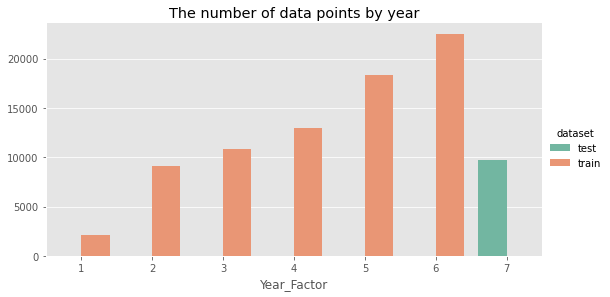

In [18]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

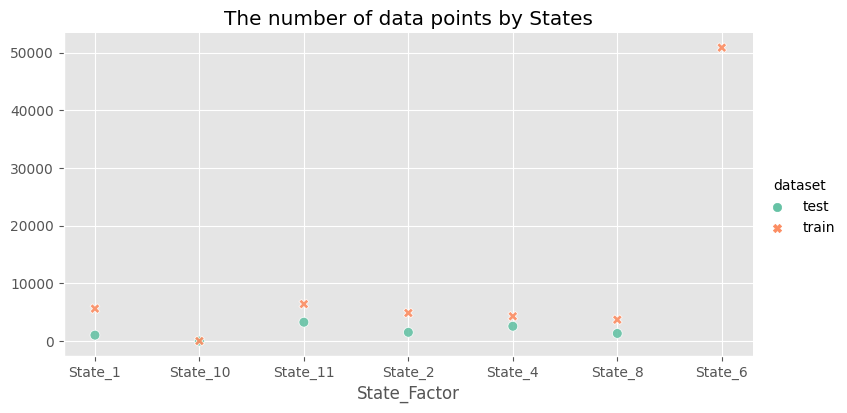

In [19]:
ax = sns.relplot(x='State_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=2,
                 height=4,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by States",
    ylabel=None)

Text(0.5, 0, '')

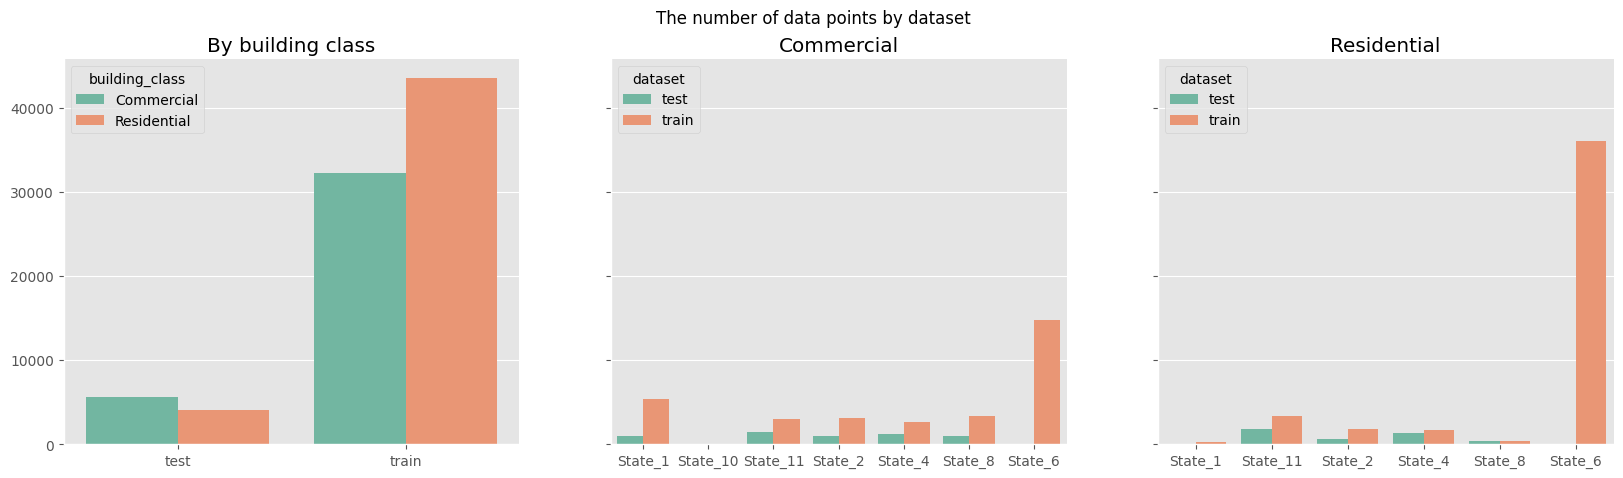

In [20]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

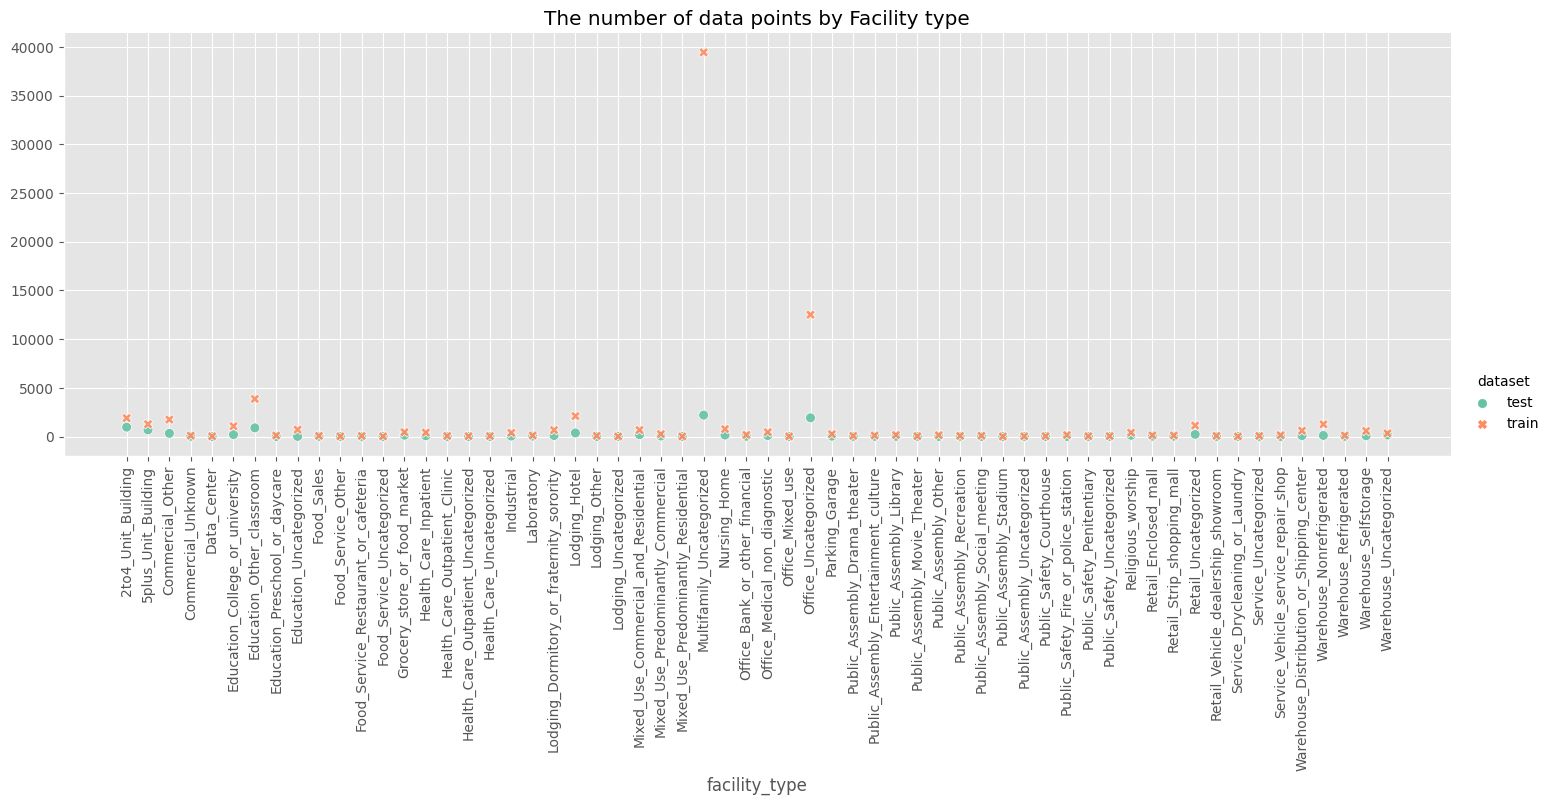

In [21]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

In [22]:
df_all['year_built'].value_counts().index.sort_values()

Float64Index([   0.0, 1600.0, 1649.0, 1732.0, 1756.0, 1789.0, 1799.0, 1800.0,
              1811.0, 1815.0,
              ...
              2007.0, 2008.0, 2009.0, 2010.0, 2011.0, 2012.0, 2013.0, 2014.0,
              2015.0, 2016.0],
             dtype='float64', length=183)

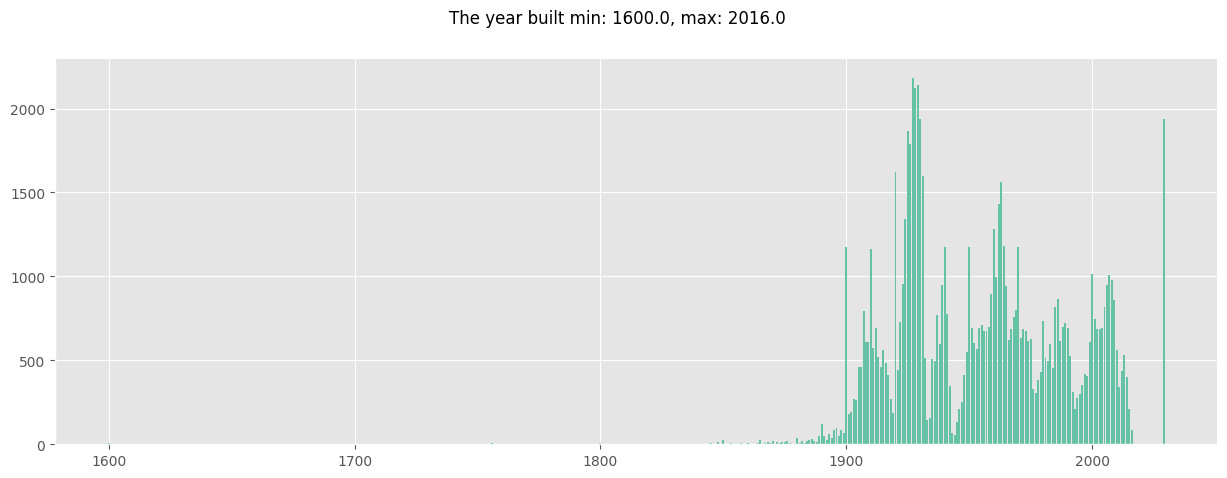

In [23]:
temp = df_all[['year_built']].fillna(2029).replace({0:2029}).astype('category').value_counts().reset_index().rename({0:'count'},axis=1)\
            .sort_values('year_built')
# temp['year_built'] = temp['year_built'].astype('category')
fig, ax = plt.subplots(figsize=(15,5))

ax=plt.bar(temp['year_built'],
           temp['count']
          )

fig.suptitle(f"The year built min: {min(temp['year_built'])}, max: {max(df_all['year_built'])}");

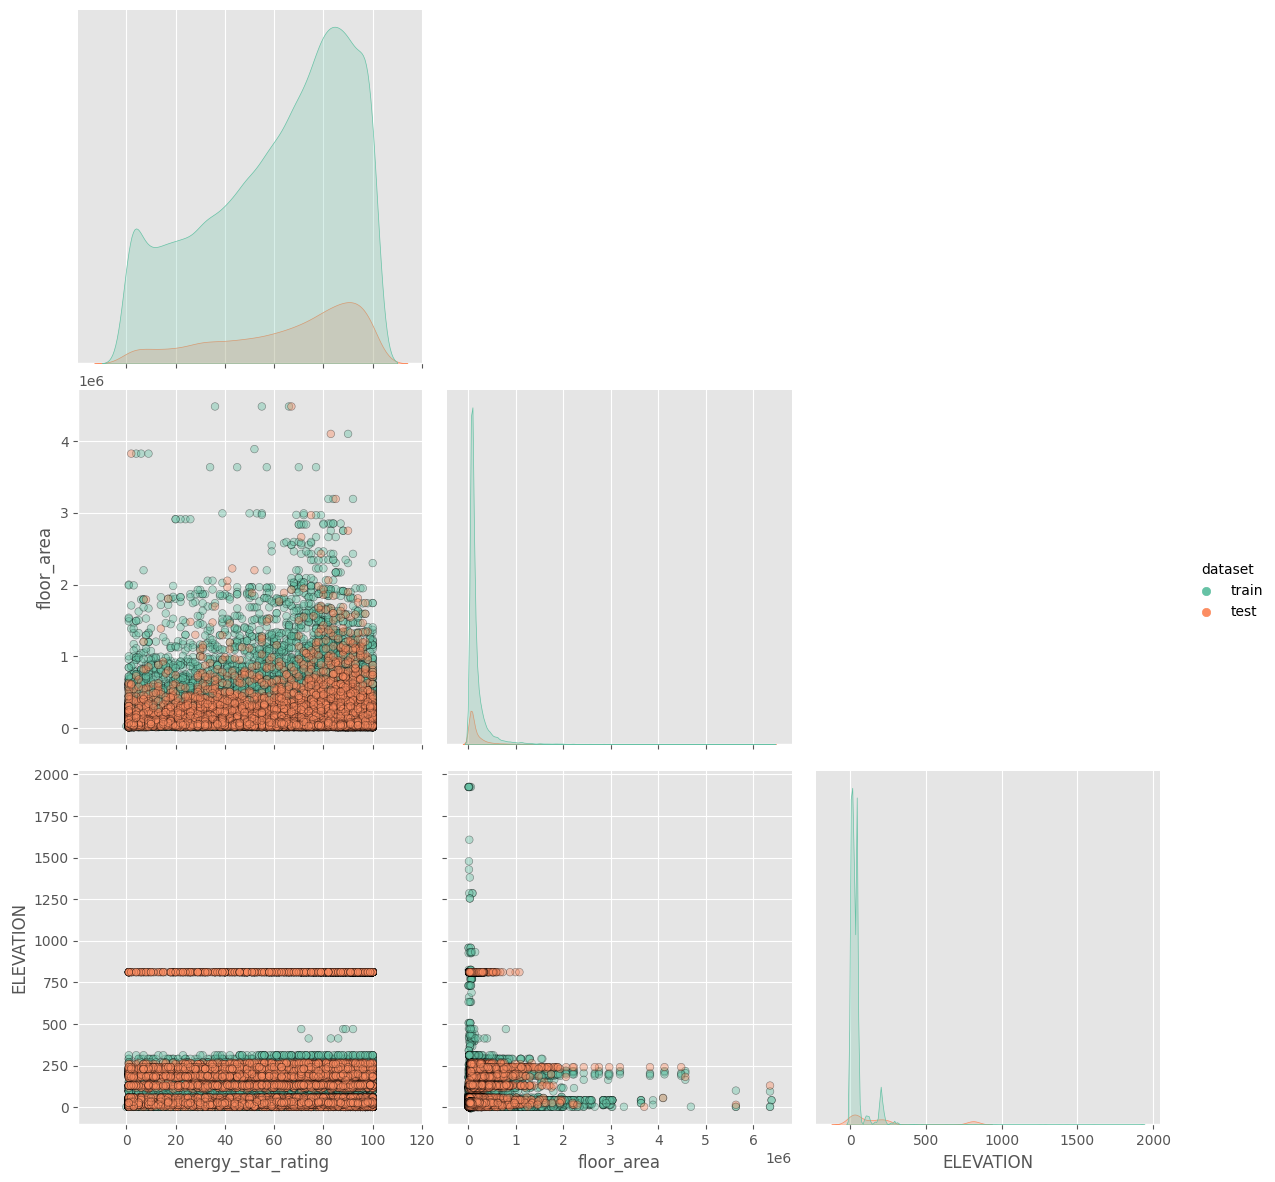

In [24]:
sns.pairplot(df_all,
            vars=['energy_star_rating','floor_area','ELEVATION'], 
            hue='dataset',
            height=4,
            plot_kws = {'alpha': 0.4, 's': 30, 'edgecolor': 'k'},
            corner=True
           );

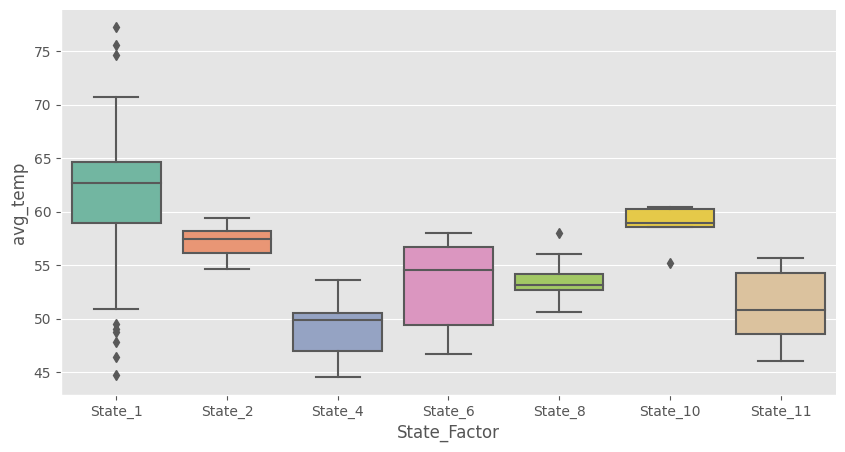

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');

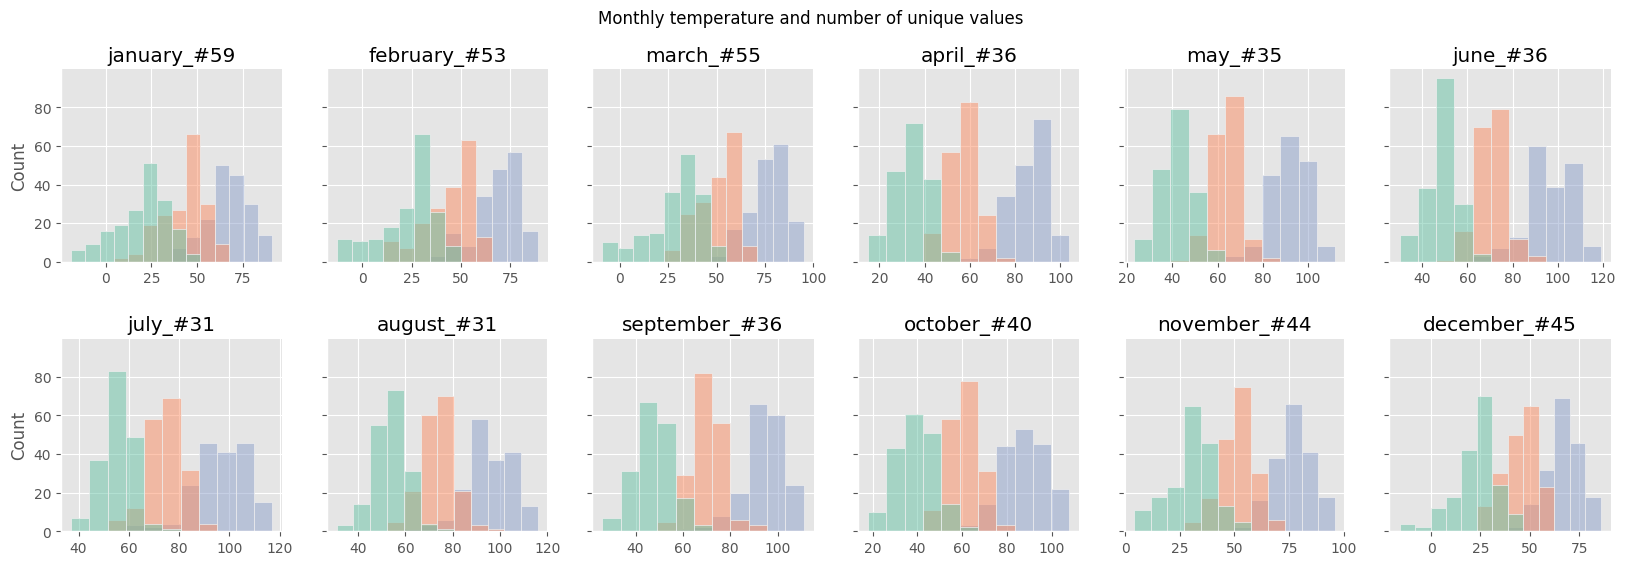

In [26]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

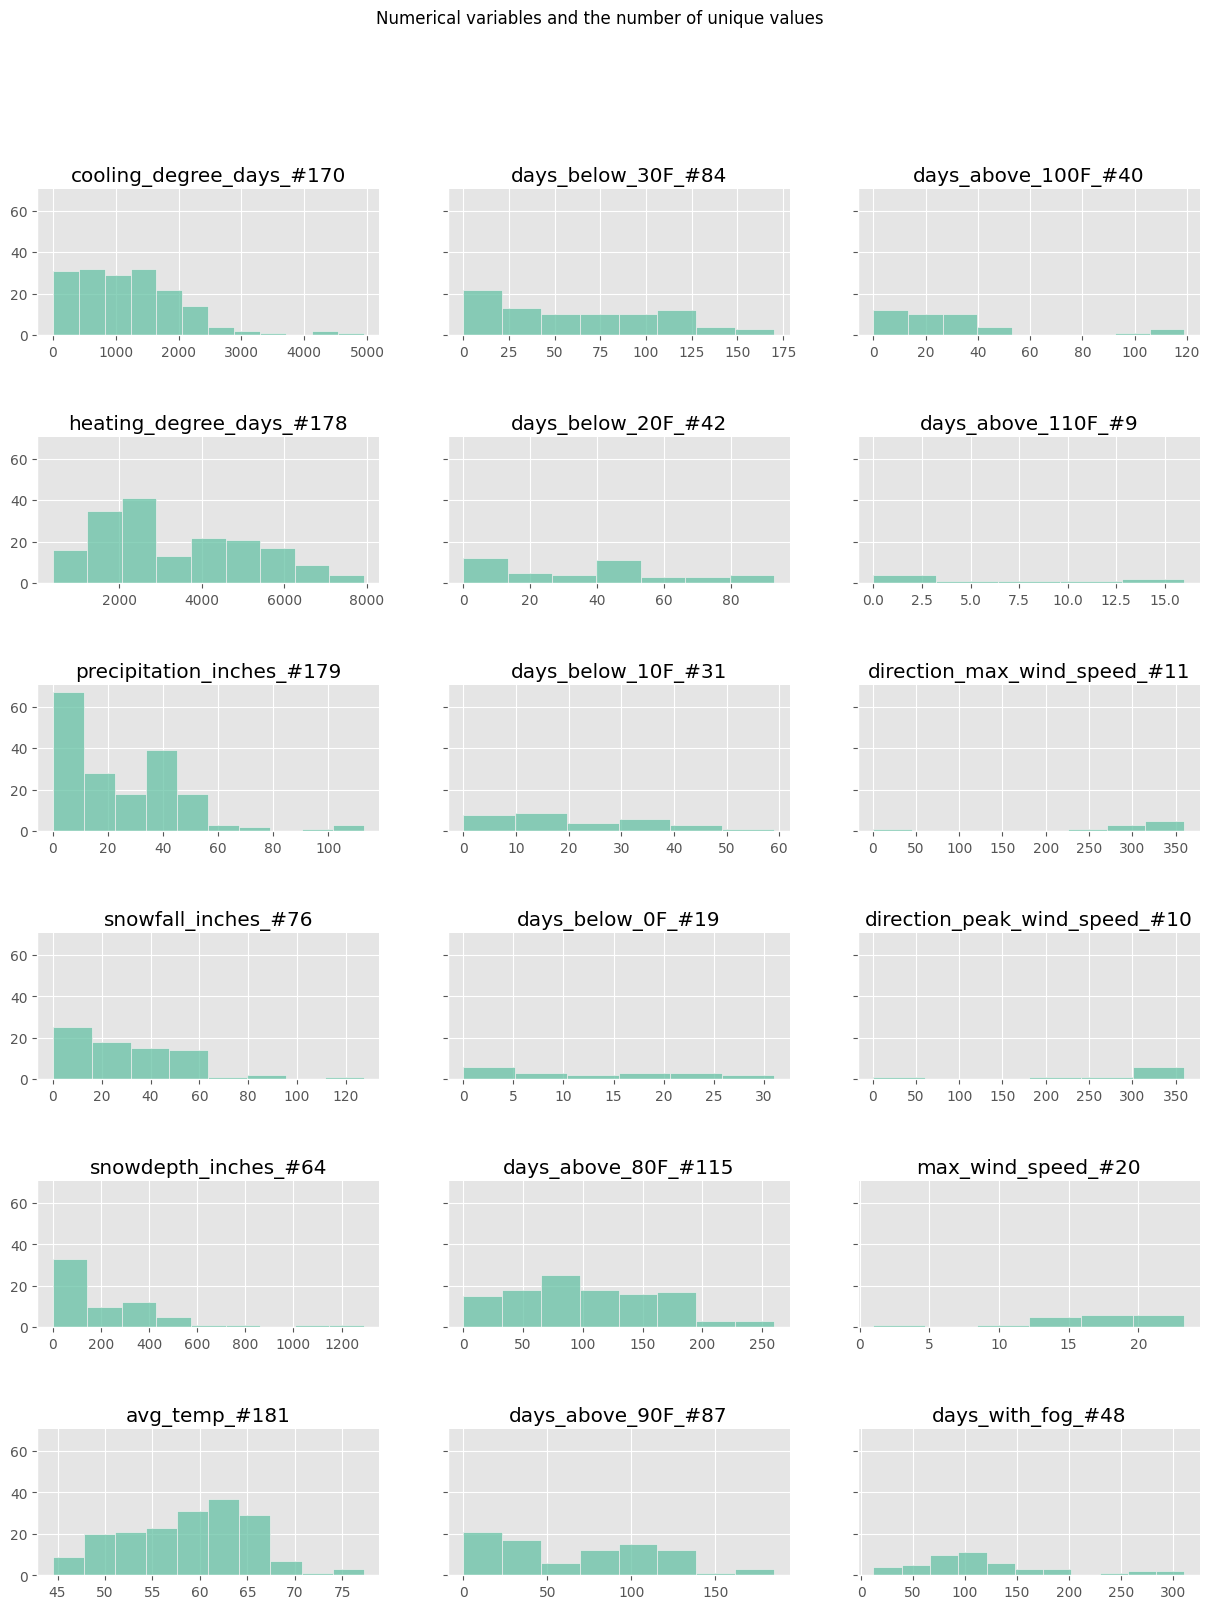

In [27]:
cols=['cooling_degree_days','heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'direction_max_wind_speed',
       'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']

fig, ax = plt.subplots(6,3, figsize=(15,18), sharey=True)
fig.suptitle("Numerical variables and the number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e,0], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    elif (e>=6) & (e<=11):
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-6,1], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[e-12,2], legend=False)\
        .set(title=c+"_#"+str(len(df_all[c].unique())), ylabel=None, xlabel=None)
        
plt.subplots_adjust(hspace=0.7)

#### Target Variable Exploration (EUI)

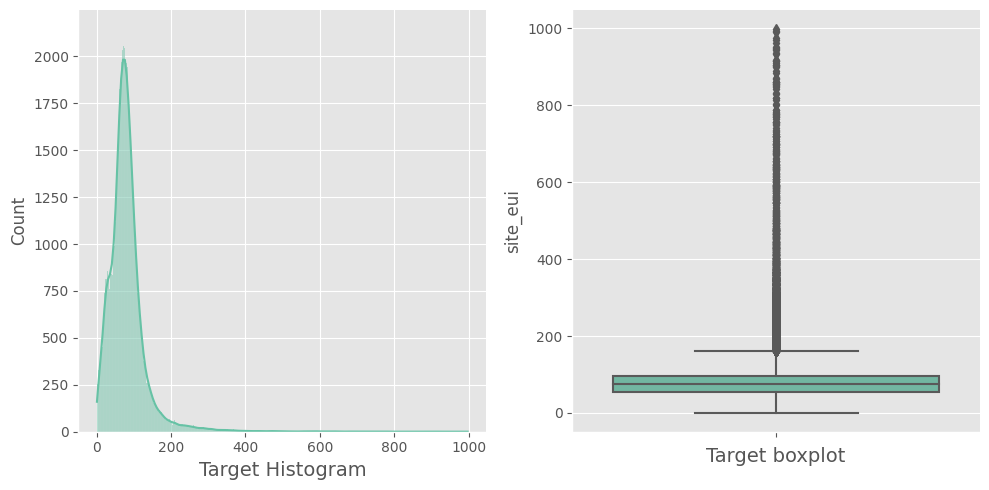

In [28]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
cp = sns.histplot(x=df_all['site_eui'], kde=True, palette='Set2')
ax1.set_xlabel('Target Histogram', fontsize=14)
ax2 = plt.subplot(1,2,2)
sns.boxplot(y=df_all['site_eui'], palette='Set2')
ax2.set_xlabel('Target boxplot', fontsize=14)
plt.tight_layout();

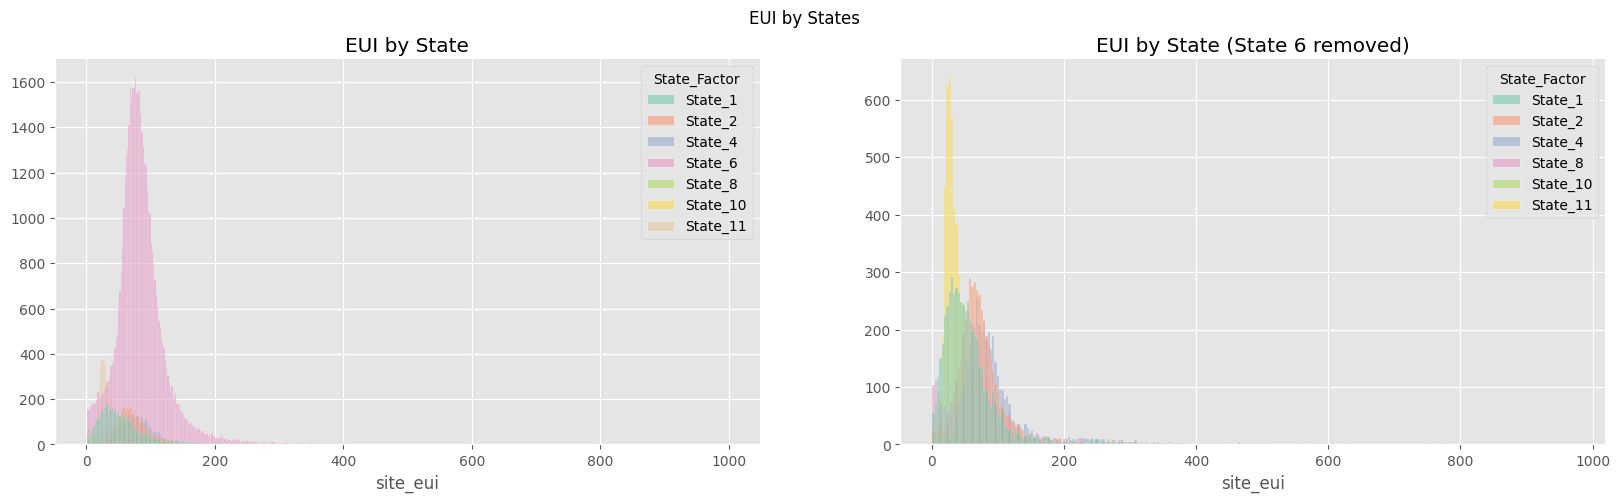

In [29]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui', hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

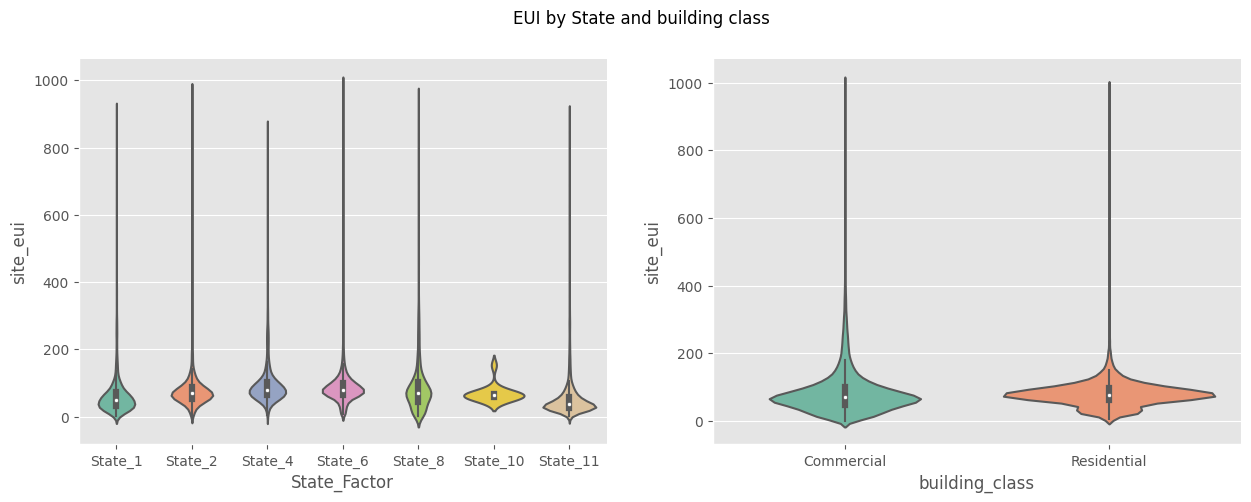

In [30]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("EUI by State and building class")

sns.violinplot(data=df_all, y='site_eui', x='State_Factor', ax=ax[0])
sns.violinplot(data=df_all, y='site_eui', x='building_class', ax=ax[1]);

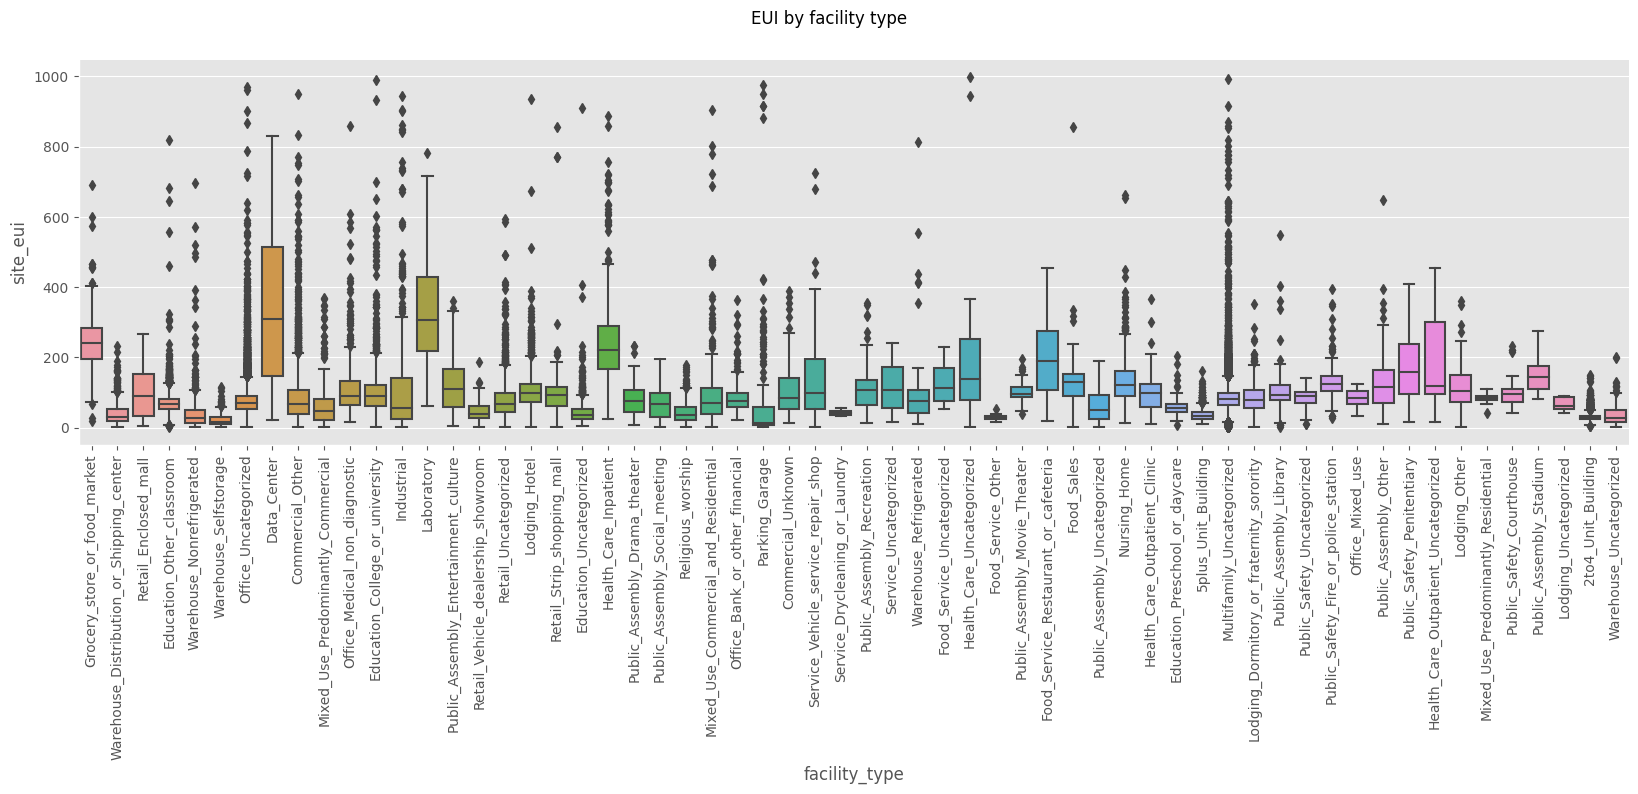

In [31]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

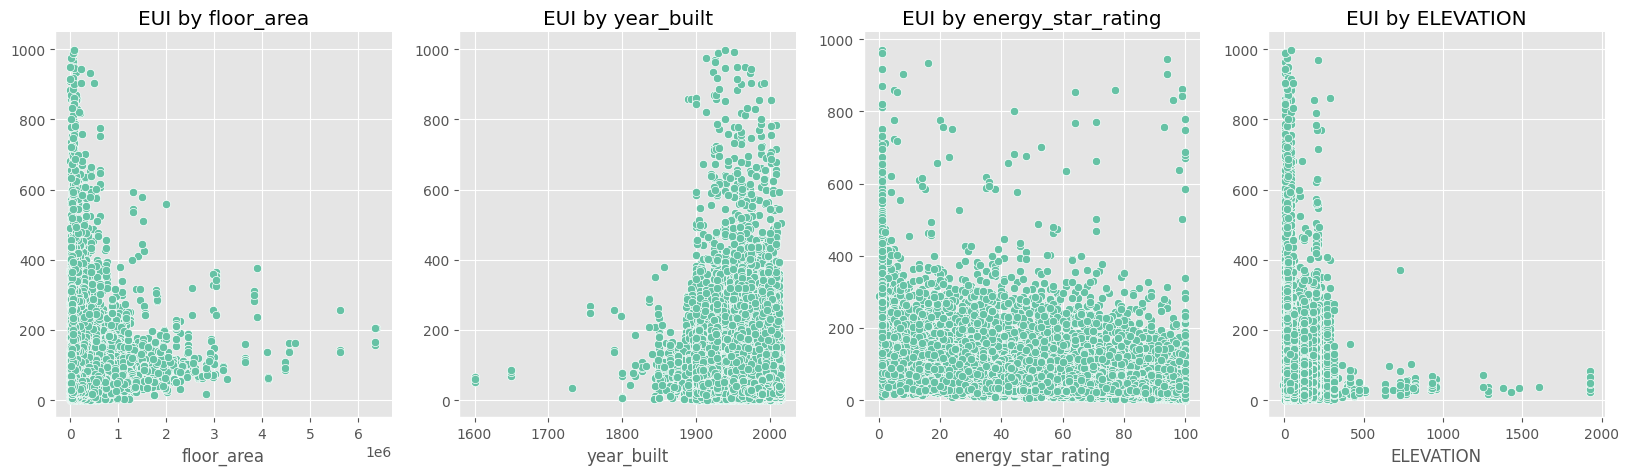

In [32]:
fig, ax = plt.subplots(1,4, figsize=(20,5))

for e, col in enumerate(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION']):
    if col =='year_built':
        sns.scatterplot(data=df_all[(df_all['year_built']!=0) & (df_all['year_built'].notna())], 
                        x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None)
    else:
        sns.scatterplot(data=df_all, x=col, y='site_eui', ax=ax[e]).set(title='EUI by '+ col, ylabel=None);

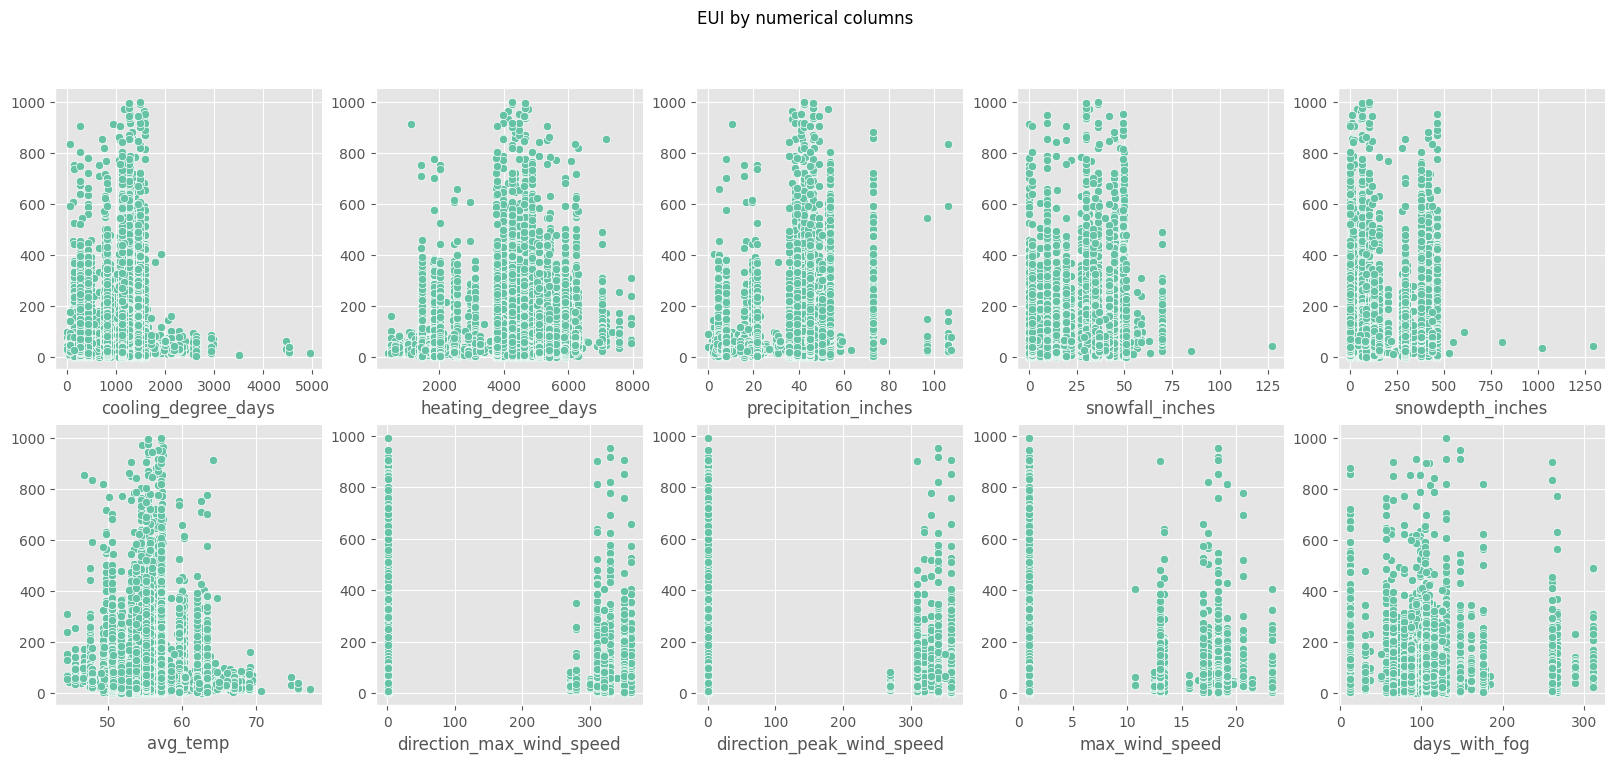

In [33]:
cols=[['cooling_degree_days','heating_degree_days', 'precipitation_inches', 
      'snowfall_inches','snowdepth_inches'], 
      ['avg_temp', 
      'direction_max_wind_speed','direction_peak_wind_speed', 'max_wind_speed', 
      'days_with_fog']]

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('EUI by numerical columns')

for e1, l in enumerate(cols):
    for e2, col in enumerate(l):
        sns.scatterplot(data=df_all, 
                        x=col, y='site_eui', ax=ax[e1, e2]).set(ylabel=None);

###  Preprocessing

In [34]:
## Remove the duplicate
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [35]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

Null imputation for categorical values: **KNN Imputing**

In [36]:
cats = ['State_Factor', 'facility_type', 'building_class']
for col in cats:
    dummies = pd.get_dummies(df_all[col], dummy_na=False)
    for ohe_col in dummies:
        df_all[f'ohe_{col}_{ohe_col}'] = dummies[ohe_col]

In [37]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,ohe_facility_type_Multifamily_Uncategorized,ohe_facility_type_Nursing_Home,ohe_facility_type_Office_Bank_or_other_financial,ohe_facility_type_Office_Medical_non_diagnostic,ohe_facility_type_Office_Mixed_use,ohe_facility_type_Office_Uncategorized,ohe_facility_type_Parking_Garage,ohe_facility_type_Public_Assembly_Drama_theater,ohe_facility_type_Public_Assembly_Entertainment_culture,ohe_facility_type_Public_Assembly_Library,ohe_facility_type_Public_Assembly_Movie_Theater,ohe_facility_type_Public_Assembly_Other,ohe_facility_type_Public_Assembly_Recreation,ohe_facility_type_Public_Assembly_Social_meeting,ohe_facility_type_Public_Assembly_Stadium,ohe_facility_type_Public_Assembly_Uncategorized,ohe_facility_type_Public_Safety_Courthouse,ohe_facility_type_Public_Safety_Fire_or_police_station,ohe_facility_type_Public_Safety_Penitentiary,ohe_facility_type_Public_Safety_Uncategorized,ohe_facility_type_Religious_worship,ohe_facility_type_Retail_Enclosed_mall,ohe_facility_type_Retail_Strip_shopping_mall,ohe_facility_type_Retail_Uncategorized,ohe_facility_type_Retail_Vehicle_dealership_showroom,ohe_facility_type_Service_Drycleaning_or_Laundry,ohe_facility_type_Service_Uncategorized,ohe_facility_type_Service_Vehicle_service_repair_shop,ohe_facility_type_Warehouse_Distribution_or_Shipping_center,ohe_facility_type_Warehouse_Nonrefrigerated,ohe_facility_type_Warehouse_Refrigerated,ohe_facility_type_Warehouse_Selfstorage,ohe_facility_type_Warehouse_Uncategorized,ohe_building_class_Commercial,ohe_building_class_Residential
0,3,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,7,State_1,Commercial,Commercial_Other,10149.0,1931.0,NaN,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,State_1,Commercial,Commercial_Other,10755.0,1937.0,NaN,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_8,Residential,Multifamily_Uncategorized,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,...,1,0,0,

In [38]:
knn_imputing = False
target='site_eui'

if knn_imputing:
    imputer = KNNImputer(n_neighbors=7)
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df = df_all.drop(tmp.columns, axis=1)
    df1 = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
    
    tmp.to_csv('Datasets/imputer_tmp.csv', index=False)
    df1.to_csv('Datasets/imputer_df1.csv', index=False)
    joblib.dump(imputer, 'Models/knn_imputer.pkl')

else:
    df1 = pd.read_csv('Datasets/imputer_df1.csv')
    tmp = df_all[['State_Factor', 'building_class', 'facility_type', 'dataset', target]]
    df_all = df_all.drop(tmp.columns, axis=1)
    
    for col in tmp.columns:
        df_all[col]=tmp[col]
    for col in df1.columns:
        df_all[col] = df1[col]

In [39]:
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[f'te_{col}'] = encoder.fit_transform(df_all[col], df_all[target])
    


### Feature Engineering

In [40]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)


# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [41]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

In [42]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

#### Checking target variable transformation

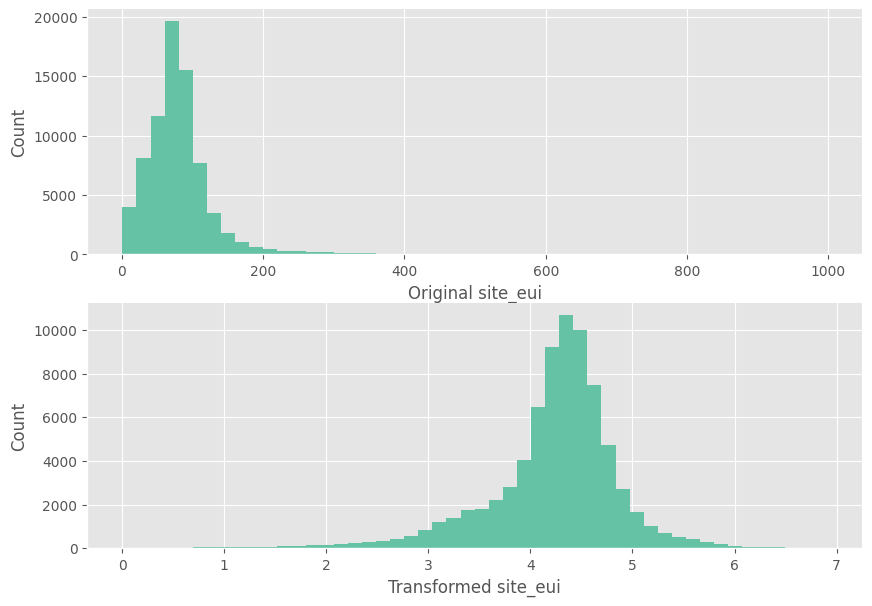

In [43]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

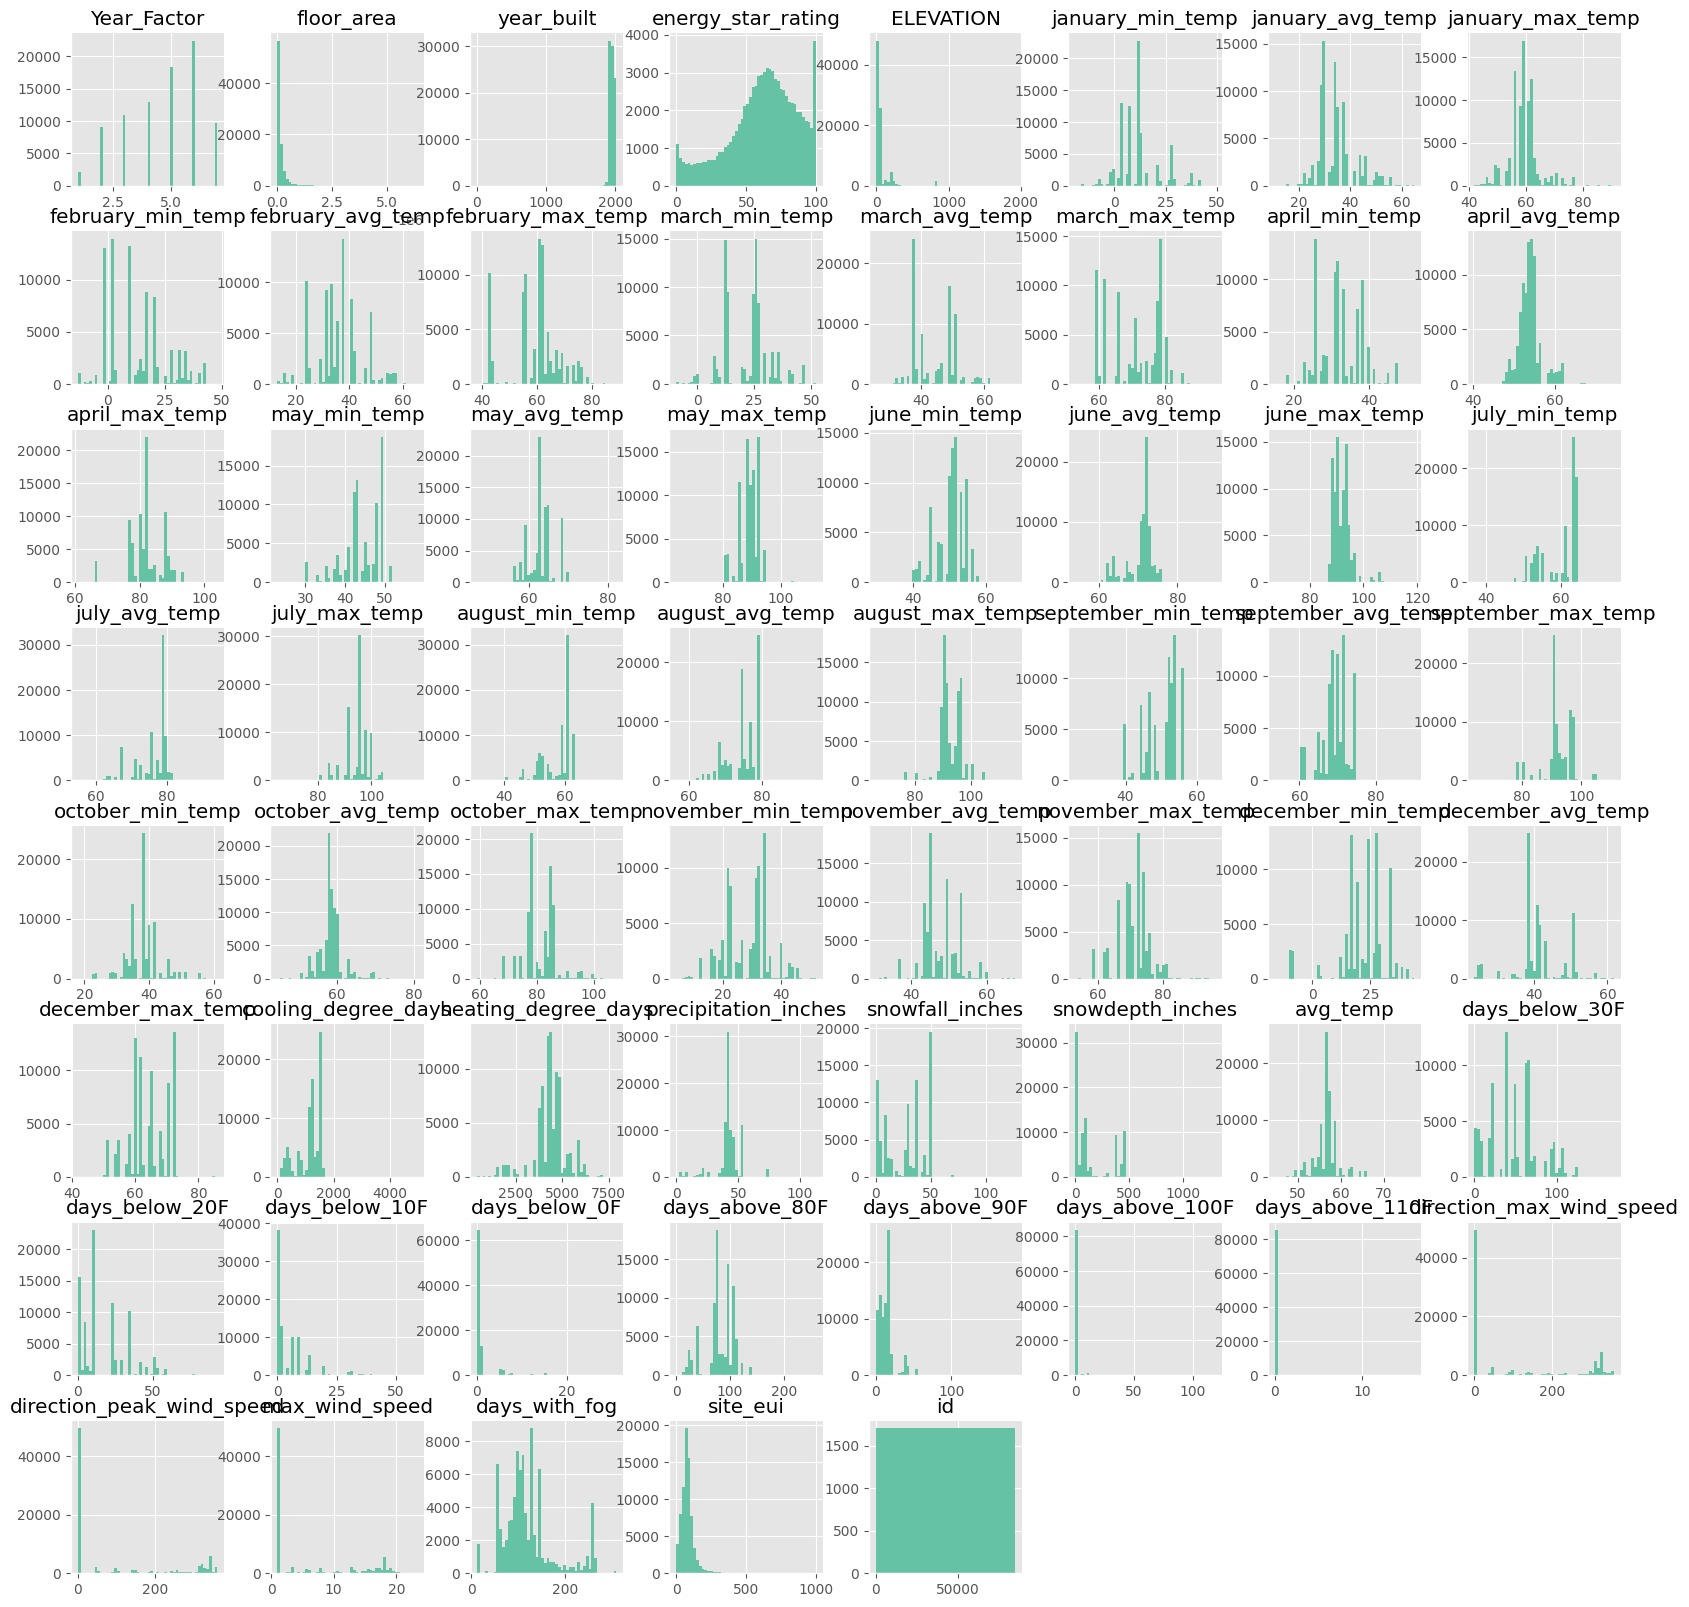

In [44]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [45]:
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.716545
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [46]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

#### Saving feature dataset

In [48]:
saved = False
if saved:
    %pip install pickle5 --quiet
    import pickle5 as pickle
    data_path = 'Datasets/feature_transformed_set.pkl'
    with open(data_path, "rb") as fh:
        df = pickle.load(fh)
else:
    df_all.to_pickle('Datasets/feature_transformed_set.pkl')

In [49]:
df_all.shape

(85462, 165)

In [50]:
df_all.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,building_class,facility_type,dataset,site_eui,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,Commercial,Commercial_Other,train,6.800000,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,Commercial,Commercial_Other,train,8.200000,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,Commercial,Commercial_Other,train,12.300000,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,Commercial,Commercial_Other,test,NaN,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,Commercial,Commercial_Other,train,63.083288,62.196194,85.755239,92.642037,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849


### Baseline Modeling

In [51]:
cats = ['State_Factor', 'facility_type', 'building_class', 'days_above_100F', 'days_above_110F']

# typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [52]:
df_all.drop(columns=cats)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,ohe_building_class_Commercial,ohe_building_class_Residential,dataset,site_eui,te_State_Factor,te_building_class,te_facility_type,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,38.428571,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,1.0,0.0,train,6.800000,62.196194,85.755239,92.642037,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,0.840888
1,4.0,10149.0,1931.0,43.571429,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,1.0,0.0,train,8.200000,62.196194,85.755239,92.642037,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.361889
2,5.0,10149.0,1931.0,37.571429,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,1.0,0.0,train,12.300000,62.196194,85.755239,92.642037,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,0.635726
3,7.0,10149.0,1931.0,60.285714,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,1.0,0.0,test,NaN,62.196194,85.755239,92.642037,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.020063
4,3.0,10755.0,1937.0,45.571429,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,1.0,0.0,train,63.083288,62.196194,85.755239,92.642037,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,5.007849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7.0,900000.0,1960.0,90.000

In [53]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui'] #y_train

train = train.drop(['id', 'dataset', 'site_eui'], axis=1) #X_train
test = test.drop(['id', 'dataset', 'site_eui'], axis=1) #X_test

#### Label Encoding discrete features

In [55]:
# get discrete end categorical features colums indexes 
# needed later for the cat bosst model
cats_discrete_idx = np.where(train.dtypes != 'float64')[0]
# create the label
le = LabelEncoder()
for col_idx in cats_discrete_idx:
    train.iloc[:, col_idx] = le.fit_transform(train.iloc[:, col_idx].astype(str))
    test.iloc[:, col_idx] = le.transform(test.iloc[:, col_idx].astype(str))

In [56]:
print("Label Encoded Columns:")
for i in cats_discrete_idx:
    print(train.columns[i])

Label Encoded Columns:
days_above_100F
days_above_110F
State_Factor
building_class
facility_type


In [58]:
y_test = pd.read_csv('Datasets/y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 162)
Test: (9705, 162)
Samples:  (75757,)
Targets:  (9705,)


#### Catboost

In [59]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
                         

In [60]:
catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

y_pred = catb.predict(X_test)

0:	learn: 57.8524103	test: 61.1937812	best: 61.1937812 (0)	total: 609ms	remaining: 5m 3s
75:	learn: 44.4581762	test: 68.4988268	best: 61.1937812 (0)	total: 32.1s	remaining: 2m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 61.19378118
bestIteration = 0

Shrink model to first 1 iterations.


In [61]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 61.19378120765249
 MAE: 40.29268484855883
 MSE: 3744.6788584900432
 R2: -0.03567833304884771


#### XGBoost

In [65]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [66]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.8514058171361
 MAE: 52.41012420250038
 MSE: 6699.6526342415
 R2: -0.8529452950300322


#### RandomForest

In [67]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [68]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.8514058171361
 MAE: 52.41012420250038
 MSE: 6699.6526342415
 R2: -0.8529452950300322


### Model Evaluation

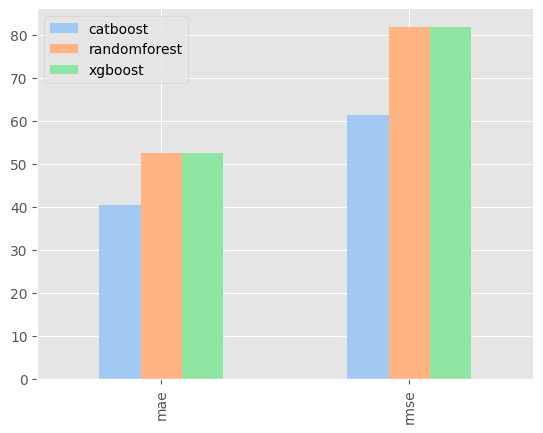

In [69]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
    "xgboost": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

### Hyperparameter Tuning

#### Using CrossValidation on CatBoost

In [71]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train,
                 eval_set=(X_test,y_test),
                 cat_features=cats_discrete_idx,
                 use_best_model=True,
                 verbose=True)

    oof = catb.predict(X_test)
    train_oof[test_idx] = oof
    test_preds += catb.predict(test)/NUM_FOLDS      
    print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))


0it [00:00, ?it/s]Warning: Overfitting detector is active, thus evaluation metric is calculated on every iteration. 'metric_period' is ignored for evaluation metric.


0:	learn: 58.0486956	test: 56.9845321	best: 56.9845321 (0)	total: 405ms	remaining: 3m 22s
75:	learn: 44.8585923	test: 44.6128787	best: 44.6128787 (75)	total: 30.4s	remaining: 2m 49s
150:	learn: 41.8165588	test: 42.5955117	best: 42.5955117 (150)	total: 59.2s	remaining: 2m 16s
225:	learn: 40.3963736	test: 41.9576829	best: 41.9576829 (225)	total: 1m 30s	remaining: 1m 50s
300:	learn: 39.4577955	test: 41.5785909	best: 41.5785909 (300)	total: 1m 58s	remaining: 1m 18s
375:	learn: 38.6958992	test: 41.3894618	best: 41.3894618 (375)	total: 2m 27s	remaining: 48.6s
450:	learn: 38.0876908	test: 41.2500005	best: 41.2491191 (449)	total: 2m 55s	remaining: 19s
499:	learn: 37.6628045	test: 41.1512341	best: 41.1512341 (499)	total: 3m 14s	remaining: 0us

bestTest = 41.15123409
bestIteration = 499



1it [03:14, 194.71s/it]

out-of-folds prdiction ==== fold_0 RMSE 6.4149227632157535


0:	learn: 57.9481090	test: 57.4005803	best: 57.4005803 (0)	total: 353ms	remaining: 2m 55s
75:	learn: 44.6895240	test: 45.0588046	best: 45.0588046 (75)	total: 29.5s	remaining: 2m 44s
150:	learn: 41.7872979	test: 43.0664251	best: 43.0664251 (150)	total: 58.3s	remaining: 2m 14s
225:	learn: 40.4737135	test: 42.3678782	best: 42.3678782 (225)	total: 1m 26s	remaining: 1m 44s
300:	learn: 39.5451638	test: 41.9713593	best: 41.9713593 (300)	total: 1m 55s	remaining: 1m 16s
375:	learn: 38.8022084	test: 41.6915931	best: 41.6915931 (375)	total: 2m 23s	remaining: 47.3s
450:	learn: 38.1268187	test: 41.4890330	best: 41.4880872 (449)	total: 2m 52s	remaining: 18.7s
499:	learn: 37.6968856	test: 41.3525245	best: 41.3525245 (499)	total: 3m 11s	remaining: 0us

bestTest = 41.35252449
bestIteration = 499



2it [06:26, 192.95s/it]

out-of-folds prdiction ==== fold_1 RMSE 6.430592854671563


0:	learn: 57.6714447	test: 58.5643331	best: 58.5643331 (0)	total: 387ms	remaining: 3m 13s
75:	learn: 44.0798297	test: 47.0411246	best: 47.0411246 (75)	total: 30.6s	remaining: 2m 50s
150:	learn: 40.9478288	test: 45.3810063	best: 45.3810063 (150)	total: 1m	remaining: 2m 20s
225:	learn: 39.5585748	test: 44.8789779	best: 44.8789779 (225)	total: 1m 30s	remaining: 1m 49s
300:	learn: 38.5406040	test: 44.6022676	best: 44.6022676 (300)	total: 2m	remaining: 1m 19s
375:	learn: 37.7108305	test: 44.4454239	best: 44.4449798 (374)	total: 2m 29s	remaining: 49.3s
450:	learn: 37.0202803	test: 44.3265440	best: 44.3243300 (447)	total: 2m 59s	remaining: 19.5s
499:	learn: 36.6086520	test: 44.2542982	best: 44.2542982 (499)	total: 3m 18s	remaining: 0us

bestTest = 44.25429823
bestIteration = 499



3it [09:45, 195.72s/it]

out-of-folds prdiction ==== fold_2 RMSE 6.652390422375879


0:	learn: 58.4395723	test: 55.3248295	best: 55.3248295 (0)	total: 411ms	remaining: 3m 25s
75:	learn: 44.9093731	test: 43.3822308	best: 43.3822308 (75)	total: 30.3s	remaining: 2m 49s
150:	learn: 41.7674459	test: 41.7508126	best: 41.7508126 (150)	total: 1m	remaining: 2m 19s
225:	learn: 40.2704316	test: 41.2466661	best: 41.2466661 (225)	total: 1m 29s	remaining: 1m 49s
300:	learn: 39.3020882	test: 41.0137435	best: 41.0099220 (299)	total: 1m 59s	remaining: 1m 19s
375:	learn: 38.5910794	test: 40.8936492	best: 40.8914751 (363)	total: 2m 29s	remaining: 49.4s
450:	learn: 37.9267501	test: 40.7925337	best: 40.7925337 (450)	total: 2m 59s	remaining: 19.5s
499:	learn: 37.5473204	test: 40.7339188	best: 40.7332834 (497)	total: 3m 19s	remaining: 0us

bestTest = 40.7332834
bestIteration = 497

Shrink model to first 498 iterations.


4it [13:05, 197.28s/it]

out-of-folds prdiction ==== fold_3 RMSE 6.382263188600934


0:	learn: 57.0823684	test: 60.8186163	best: 60.8186163 (0)	total: 405ms	remaining: 3m 22s
75:	learn: 44.0263865	test: 48.3058363	best: 48.3058363 (75)	total: 30.9s	remaining: 2m 52s
150:	learn: 41.0105696	test: 46.0847110	best: 46.0847110 (150)	total: 1m	remaining: 2m 20s
225:	learn: 39.6786374	test: 45.3469387	best: 45.3469387 (225)	total: 1m 30s	remaining: 1m 49s
300:	learn: 38.8700470	test: 45.0371513	best: 45.0371513 (300)	total: 1m 59s	remaining: 1m 19s
375:	learn: 38.2578445	test: 44.8530983	best: 44.8530983 (375)	total: 2m 29s	remaining: 49.2s
450:	learn: 37.6660088	test: 44.6901407	best: 44.6896809 (449)	total: 2m 57s	remaining: 19.3s
499:	learn: 37.3259984	test: 44.6062586	best: 44.6048906 (498)	total: 3m 16s	remaining: 0us

bestTest = 44.60489065
bestIteration = 498

Shrink model to first 499 iterations.


5it [16:22, 196.48s/it]

out-of-folds prdiction ==== fold_4 RMSE 6.678689283252963


#### Using Optuna with Random Forest

In [72]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [73]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [74]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2022-08-10 22:36:03,773] A new study created in memory with name: no-name-f444738e-1348-426e-9789-18d5a0430d1d
[I 2022-08-10 23:25:38,675] Trial 0 finished with value: -42.623080448680085 and parameters: {'n_estimators': 262, 'max_depth': 11, 'min_samples_split': 7, 'max_features': 0.3852192355365439}. Best is trial 0 with value: -42.623080448680085.


Best score: -42.623080448680085
Optimized parameters: {'n_estimators': 262, 'max_depth': 11, 'min_samples_split': 7, 'max_features': 0.3852192355365439}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
CPU times: total: 7min 44s
Wall time: 49min 34s


In [75]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=11, max_features=0.3852192355365439,
                      min_samples_split=7, n_estimators=262)

#### Final Evaluation

Text(0.5, 0, 'iteration')

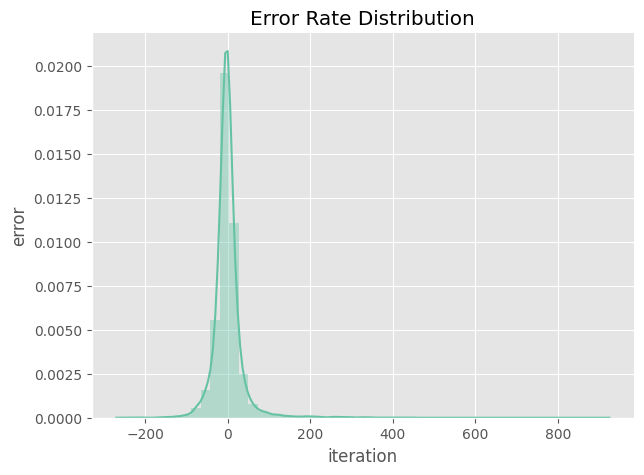

In [76]:
### Final Evaluation
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

Text(0.5, 0, 'iteration')

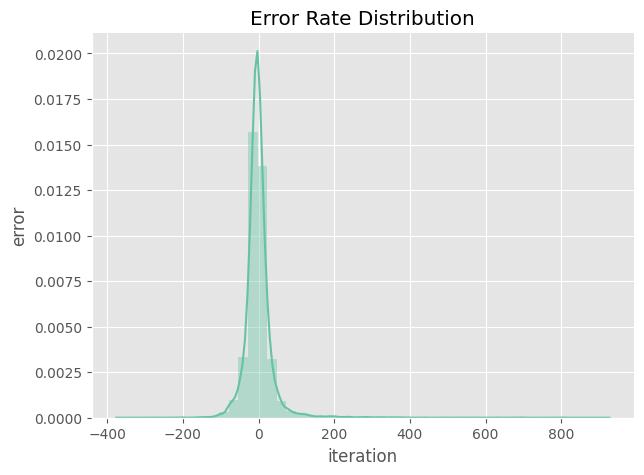

In [77]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

### Saving Models

In [78]:
with open('Models/rf_tuned_final.joblib', 'wb') as f:
    joblib.dump(rf_tuned_model, f, compress=1)

with open('Models/catb_best_final.joblib', 'wb') as f:
    joblib.dump(catb,f,compress=3)

In [79]:
## Load models here
load = False
if load:
    with open('Models/rf_tuned_final.joblib', 'rb') as f:
        rf = joblib.load(f)

    with open('Models/catb_best_final.joblib', 'rb') as f:
        catb = joblib.load(f)